In [10]:
import torch 
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torchvision import datasets
from torchsummary import summary
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import cv2 
from skimage import measure
%matplotlib inline

# Colormaps for 2 class facade segmentation (windows and "not windows") #

In [11]:

def encode_to_classes(RGB_array):
    """
    input: RGB mask [H=256 x W=256 x C=3]
    create 2 binary masks for background and windows (2 channels for unet algorithm output)
    return: np.array of [H=256 x W=256 x C=2]
    """
    local_rgb = RGB_array
    NP_ARRAY_CLASSIFIED_BACKGROUND = np.zeros(shape=(local_rgb.shape[0],local_rgb.shape[1]))
    NP_ARRAY_CLASSIFIED_WINDOWS = np.zeros(shape=(local_rgb.shape[0],local_rgb.shape[1]))
    NP_ARRAY_TRANSFORMED = np.zeros(shape=(local_rgb.shape[0],local_rgb.shape[1], 3))
    for i in range(local_rgb.shape[0]):
        for j in range(local_rgb.shape[1]):
            R = local_rgb[i,j,0]
            G = local_rgb[i,j,1]
            B = local_rgb[i,j,2]

            if 0<=R<=40 and 70<=G<=150 and 240<=B<=255:
                NP_ARRAY_CLASSIFIED_WINDOWS[i,j] = 1
                NP_ARRAY_TRANSFORMED[i,j,0] = 255
                NP_ARRAY_TRANSFORMED[i,j,1] = 0
                NP_ARRAY_TRANSFORMED[i,j,2] = 0
               
            else:
                NP_ARRAY_CLASSIFIED_BACKGROUND[i,j] = 1
                NP_ARRAY_TRANSFORMED[i,j,0] = 0
                NP_ARRAY_TRANSFORMED[i,j,1] = 0
                NP_ARRAY_TRANSFORMED[i,j,2] = 255
        output = (np.stack([NP_ARRAY_CLASSIFIED_WINDOWS.astype(np.uint8), NP_ARRAY_CLASSIFIED_BACKGROUND.astype(np.uint8)], axis=-1), NP_ARRAY_TRANSFORMED)
    return output


cwd = os.getcwd()
# path_base = os.path.join(cwd, r'dataset\trainB')
# path_trans = os.path.join(cwd,r'dataset\pixels_segmentation\trainB')
# path_segmented = os.path.join(cwd, r'dataset\pixels_segmentation\npy_trainB')

#save .npy arrays and cmaps to disk
# for i in range(400):
#     image = Image.open(os.path.join(path_base, f"{i+1}_B.jpg"))
#     image = np.array(image)
#     classified, img_trans = classify_segmented(image)
#     #img_trans = Image.fromarray(img_trans)
#     #img_trans.save(os.path.join(path_trans, f"{i+1}.jpg"))
#     np.save(os.path.join(path_segmented, f"{i+1}_B"), classified, allow_pickle=False)

# Custom Dataset class and instances #

In [12]:

transform_image = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

transform_label = transforms.Compose(
    [transforms.ToTensor()])


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform_image, transform_label, data_index):
        self.img_labels = pd.read_csv(annotations_file, sep=';')
        self.img_dir = img_dir
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.data_index = data_index

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, self.data_index])
        image = np.array(Image.open(img_path).convert('RGB'))
        image_label = np.load(img_label_path)
        text_label = self.img_labels.iloc[idx,3]
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_label:
            image_label = self.transform_label(image_label)
        return image, image_label, text_label


training_dataset = CustomImageDataset(annotations_file=os.path.join(cwd, r'dataset\annotation_train.csv'),
                                   img_dir=os.path.join(cwd, r'dataset'),
                                   transform_image=transform_image,
                                   transform_label=transform_label,
                                   data_index=2,
                                   )

validation_dataset = CustomImageDataset(annotations_file=os.path.join(cwd, r'dataset\annotation_validation.csv'),
                                   img_dir=os.path.join(cwd, r'dataset'),
                                   transform_image=transform_image,
                                   transform_label=transform_label,
                                   data_index=2,
                                   )



# DataLoader instances #

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


# Unet Model implementation #

In [14]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1) #1
        self.bn1 = nn.BatchNorm2d(out_c) #2 reduces internal covariance shift
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 2, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs


# Prepare and run model #

In [15]:
device = 'cuda'

LEARNING_RATE = 0.001
EPOCHS = 20
writer_step = 4


def main(execute):
    
    if execute:
        model = build_unet().to(device)
        #summary(model, (3,256,256))
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


        def train_one_epoch(epoch_index, tb_writer):
            
            running_loss = 0
            last_loss = 0

            for i, batch in enumerate(train_dataloader):
                print(f"{i+1}")
                inputs, labels, _ = batch
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs)
                loss = loss_fn(preds, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % writer_step == 1:
                    last_loss = running_loss / writer_step # loss per batch
                    print('  batch {} loss: {}'.format(i + 1, last_loss))
                    tb_x = epoch_index * len(train_dataloader) + i + 1
                    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
                    running_loss = 0.
            return last_loss



        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
        epoch_number = 0


        for epoch in range(EPOCHS):
            print('EPOCH {}:'.format(epoch_number + 1))

            model.train(True)
            avg_loss = train_one_epoch(epoch_number, writer)


            model.train(False)
            with torch.no_grad():
                running_vloss = 0.0
                for i, vdata in enumerate(validation_dataloader):
                    vinputs, vlabels, _ = vdata
                    vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                    voutputs = model(vinputs)
                    vloss = loss_fn(voutputs, vlabels)
                    running_vloss += vloss

                    avg_vloss = running_vloss / (i + 1)
                    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

                    # Log the running loss averaged per batch
                    # for both training and validation
                    writer.add_scalars('Training vs. Validation Loss',
                                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                                    epoch_number + 1)
                    writer.flush()
            epoch_number += 1


        writer.close()

        tree = os.walk(cwd, topdown=True)

        for root, dirs, files in tree:
            for name in files:
                if '.pth' in os.path.join(cwd, name):
                    os.remove(os.path.join(cwd, name))
                    break
            break

        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path + '.pth')

main(True)

EPOCH 1:
1
2
  batch 2 loss: 0.0012642476940527558
3
4
5
6
  batch 6 loss: 0.002092427748721093
7
8
9
10
  batch 10 loss: 0.001593366265296936
11
12
13
14
  batch 14 loss: 0.0013498928165063262
15
16
17
18
  batch 18 loss: 0.001142870809417218
19
20
21
22
  batch 22 loss: 0.0010847502417163923
23
24
25
LOSS train 0.0010847502417163923 valid 0.0021107483189553022
LOSS train 0.0010847502417163923 valid 0.0021430719643831253
LOSS train 0.0010847502417163923 valid 0.0021124687045812607
LOSS train 0.0010847502417163923 valid 0.0021901456639170647
LOSS train 0.0010847502417163923 valid 0.0021939470898360014
LOSS train 0.0010847502417163923 valid 0.0021205972880125046
LOSS train 0.0010847502417163923 valid 0.002089844550937414
EPOCH 2:
1
2
  batch 2 loss: 0.00047701971197966486
3
4
5
6
  batch 6 loss: 0.0011178001877851784
7
8
9
10
  batch 10 loss: 0.0008730996196391061
11
12
13
14
  batch 14 loss: 0.0009374032961204648
15
16
17
18
  batch 18 loss: 0.0007987196295289323
19
20
21
22
  batch 22

# Make Predictions #

In [16]:

model = build_unet().to('cuda')

tree = os.walk(cwd, topdown=True)
for root, dirs, files in tree:
    for name in files:
        if '.pth' in os.path.join(cwd, name):
            model_path = os.path.join(cwd, name)
            break
    break

model.load_state_dict(torch.load(model_path))
image_test_path = os.path.join(cwd, '68_A.jpg') 

my_transforms = transforms.Compose([
                                    transforms.Resize((256,256)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                    ])
image = Image.open(image_test_path)
image = my_transforms(image)
image = image.clone().detach().cuda()

image.to(device)

output = model(image.unsqueeze(0))

sm = nn.Softmax2d()
output = sm(output).squeeze(0)
output = torch.permute(output, (1,2,0))
image_classes = output.cpu().detach().numpy()

image = np.zeros(shape=(256,256,3)).astype(np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image_classes[i,j,0] >= 0.5:
            image[i,j,0] = 255
            image[i,j,1] = 0
            image[i,j,2] = 0
        else:
            image[i,j,0] = 0
            image[i,j,1] = 0
            image[i,j,2] = 255
image = Image.fromarray(image)
image.save('test_predicted_mask.jpg')

# Count number of windows #

In [17]:
test_image_path = os.path.join(cwd, 'test_predicted_mask.jpg')

def count_windows(test_img_path):
    if os.path.exists(test_image_path):
        imgray = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
        imgrgb = cv2.imread(test_image_path)

        # get contours
        contours = measure.find_contours(imgray, fully_connected='high')

        # get contours length
        contour_length_list = []
        for contour in contours:
            contour_length = 0
            for i in range(len(contour)-1):
                contour_length += cv2.norm(contour[i], contour[i+1], cv2.NORM_L2)
            contour_length_list.append(contour_length)

        contour_length_array = np.array(contour_length_list)

        contours_mean = np.mean(contour_length_array)/5
        
        # remove countours with length less than 20% of mean length of all countours
        windows_count = len([length for length in contour_length_list if length > contours_mean])
        return windows_count

windows = count_windows(test_image_path)
print(windows)


29


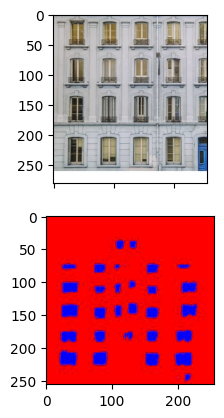

In [18]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(np.array(cv2.imread(os.path.join(cwd, 'test_image.jpg'))))
axarr[1].imshow(np.array(cv2.imread(os.path.join(cwd, 'test_predicted_mask.jpg'))))